In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman
import community.community_louvain as louvain

In [2]:
# major variables

city = 'Sicklerville'

In [3]:
def generate_graph(nodes, edges):
    '''
    Generate a networkx graph from nodes and edges dataframes
    '''
    G = nx.Graph()
    for _, row in nodes.iterrows():
        G.add_node(row['id'], name=row['name'])
    for _, row in edges.iterrows():
        G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])
    return G

In [4]:
def generate_communities(G, algorithm='girvan_newman'):
    '''
    Generate communities using the specified algorithm
    '''
    if algorithm == 'girvan_newman':
        communities = girvan_newman(G)
        first_iteration_communities = next(communities)
        return first_iteration_communities
    elif algorithm == 'louvain':
        communities = louvain.best_partition(G)
        return communities
    else:
        raise ValueError("Invalid algorithm. Choose 'girvan_newman' or 'louvain'.")

In [5]:
def visualize_graph(G, communities, city, connection):
    '''
    Visualize the graph with nodes colored by community
    '''
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G)
    
    community_colors = {}
    if isinstance(communities, tuple):
        for i, comm_nodes in enumerate(communities):
            for node in comm_nodes:
                community_colors[node] = i
    elif isinstance(communities, dict):
        for node, community_id in communities.items():
            community_colors[node] = community_id
    node_colors = [community_colors[node] for node in G.nodes()]
    
    nx.draw(G, pos,
            node_color=node_colors,
            cmap=plt.cm.tab20,
            node_size=20,
            edge_color='black',
            edgecolors='black',
            width=1,
            with_labels=False)
    
    plt.title(f"{city} - {connection}")
    plt.show()

In [6]:
# load friendship data

connection = 'friendships'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [7]:
# generate friendship graph

friendship_graph = generate_graph(nodes, edges)

In [8]:
# generate friendship communities

friendship_communities = generate_communities(friendship_graph, algorithm='girvan_newman')

print(f"Number of communities: {len(friendship_communities)}")
friendship_communities

Number of communities: 2313


({'-0MIp6WKJ8QvGnYZQ5ETyg',
  '-6MrOJCN-eIe37-LT-uPoQ',
  '-G7Zkl1wIWBBmD0KRy_sCw',
  '-NbeVN5tnwdyYAvdNkKMjw',
  '-XZOz3ViFET3IZFRGFoOpQ',
  '-YLjR2tx9xrdxKCnsrhONw',
  '-ZCf13dTuzGKMwKFRxTUwQ',
  '-bTabnaAkOjuZjJkLCBDqQ',
  '-kAQ-PSKx3i0st2B4aPpTg',
  '-nHwoXO27fuLfxAfSqAggw',
  '-ne-7caCLAk2j3kD7tzBGw',
  '-t6cqjtjhcRsVMdQUhiItA',
  '-u1pc6o7QmtdrN5i23CIng',
  '-u5CsCUHOvP5OHYaNGteZw',
  '-yNipHPnS5_wyF-qNnIbFQ',
  '0GPM8WXgZcUDV9Ynyvw9Lg',
  '0OqT_KW-0IIiAdxnv7aftA',
  '0PZ6aqFl3TE9RiAQje3K4Q',
  '0RX9w878R80Ok5iPrNBv3g',
  '0XqZvDPZoljhpoE1fCso-w',
  '0ZUHtvIiZ1DPKKDTiieuKA',
  '0hAfwMOHkaSlCKZFgWv9Rg',
  '0pcoe7P1OblJm4Pt7o6T7g',
  '0x7s5SZLY19HY_9q2o0wTw',
  '0xEO0EHf9yuNQ0rA59EH1A',
  '0zGrw6JCWTenp8fZaQNl4w',
  '13pN4tWmqKiBgYEr_t28ag',
  '178lUNiULUgxi8fdm1zXmA',
  '18m5hj8Z8yrcp5LOOemcRw',
  '1C5kFjSPdf9P74IhPy6e-w',
  '1RTdfIQ6zsjrwj0BTVwkFQ',
  '1Uc6NwkainkN_UQCfxsl-w',
  '1WrqB6OZ6-IZokQjPFTHSw',
  '1iCpZplozx4pdYhdmBZqqw',
  '1lm9t9D8Sh_YlF69ER0U4w',
  '1smSYpy1SNsLzFa1V

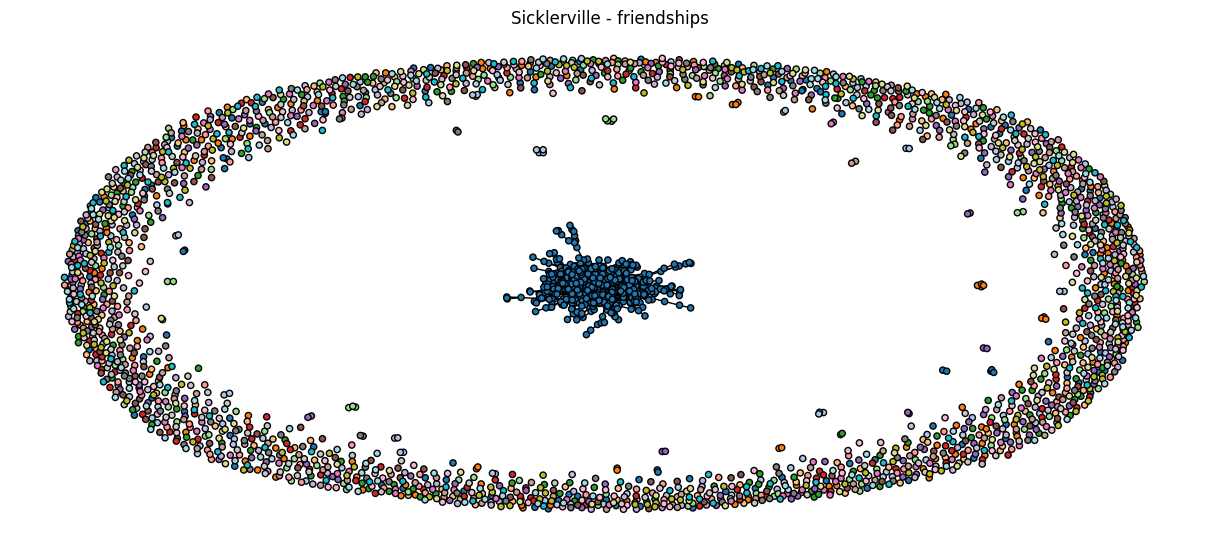

In [9]:
# visualize friendship graph

visualize_graph(friendship_graph, friendship_communities, city, connection)

In [10]:
# load review data

connection = 'business_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [11]:
# generate review graph

review_graph = generate_graph(nodes, edges)

In [12]:
# generate review communities

review_communities = generate_communities(review_graph, algorithm='louvain') # girvan_newman is incredibly slow here

print(f"Number of communities: {len(set(review_communities.values()))}")
review_communities

Number of communities: 214


{'RgDVC3ZUBqpEe6Y1kPhIpw': 0,
 'zkamNMEjihh3zN7lC7_WVw': 1,
 'gVFxZMcuG_Tal2_TnpmUPg': 2,
 'g0_x4kVvJAYuk96oCcbOmw': 3,
 '-NbeVN5tnwdyYAvdNkKMjw': 4,
 'cXtE-ZTrNx-hE7usp_f_xg': 4,
 'X6ikCQsAC4QGN-RjmvW2vA': 5,
 'SQ2J0vy4sUIrVfB6_qcbDg': 6,
 'kZnSGYEx0mLVGroGtZiXIA': 7,
 'NEnjlrr2ozU4FMmXup88wA': 8,
 'TVN3qoXU0-sateboutdCZg': 28,
 'cMPJlsuY5IQgJ8N9qICdDw': 6,
 'LI_A-_R6SQotk6fX8C0nPQ': 1,
 'CBk3GqDIhAxm1Sm5uWZynA': 6,
 'vWWvICTldmZgz-JMui2u2w': 10,
 'ApJ9YgYU-AhS4a-F5oTGHw': 1,
 'A_BF2dDDUTKGVXrqxO9mag': 1,
 'B-s-8VUnuBjGTP3d01jsyw': 1,
 'WTNE5YK9RTgP5jzStlbWjQ': 1,
 'wpfvF8ue3yr1m5xD4OrZNw': 1,
 'DsSTEHDUdXQsk7tknLtQSw': 11,
 'bi76Ih6tRv-ghYWFCJ0dag': 12,
 '9C_h-H1Z7Xz7dvbgsBrnSg': 13,
 'ZTvil7E2JbtORKm0bu6MKQ': 1,
 'ie9VaHvAaQgjMJP3Gn-AQQ': 6,
 'zebeVSHqWXuyf5fYATlojA': 4,
 '46Wi08T5D3phf3SMgi7U3w': 6,
 'Vm0fyrUjwMTDgwqV6DhqDw': 1,
 'KwC7I2KR-HlEb3KSH4a0bw': 1,
 'K1atdJqtMk__T3t_aR1sqg': 6,
 't3GdQhAtOP3GYI7JF_49vg': 14,
 '0xEO0EHf9yuNQ0rA59EH1A': 3,
 '8wHKhb9wqIHca43Xr1xJZQ': 28,
 'r

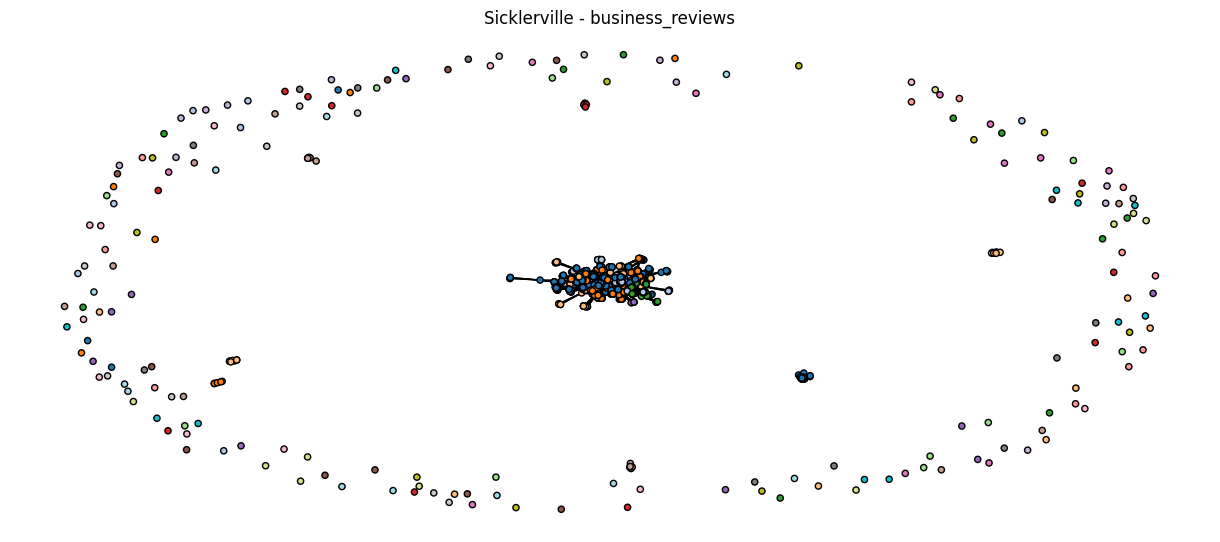

In [13]:
# visualize review graph

visualize_graph(review_graph, review_communities, city, connection)

In [14]:
# load tip data

connection = 'business_tips'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [15]:
# generate tip graph

tip_graph = generate_graph(nodes, edges)

In [16]:
# generate tip communities

tip_communities = generate_communities(tip_graph, algorithm='girvan_newman')

print(f"Number of communities: {len(tip_communities)}")
tip_communities

Number of communities: 2689


({'RgDVC3ZUBqpEe6Y1kPhIpw'},
 {'-7fV-5KlUUMatLOiIOBT-g',
  '-G7Zkl1wIWBBmD0KRy_sCw',
  '-kAQ-PSKx3i0st2B4aPpTg',
  '-miZWgdvzE8qE2GI1FtRzg',
  '09a7_-g_IJWGHBaNxsi2lA',
  '0FSUxHSq8-3Q2LfJ5zixPg',
  '0kG0OeQIqCo0Q6pwH1lJ0g',
  '0ubFDSPBD20ppJTV6Q7xrg',
  '0xEO0EHf9yuNQ0rA59EH1A',
  '178lUNiULUgxi8fdm1zXmA',
  '19b53rAhNC7jOsUhPN93mQ',
  '19db0FoXZ3Z42YlxJNc3yA',
  '1FUGzCm8Q6SQRdrVByXJUA',
  '1R0h5e662CI3AC0YCU7S4A',
  '1Uc6NwkainkN_UQCfxsl-w',
  '1hgePsmvAkZDD9fDc3KbRg',
  '2Iy_ZCjH_PuLULQCxRzZ4Q',
  '2_bid9dUjnxfeeH3NB-EAQ',
  '2qfEiGZrOYwm2HX9ai4SNA',
  '302kcRtUp1vNds8tN3tr6Q',
  '3dZm12lNAnuBVfWvwRAxTA',
  '3izDzb1kZsSzMjLdfNwLpg',
  '3lki-XYznSxGMYjlxzz-ZA',
  '4G6g_YcNnb1iNLdzvbm5eQ',
  '4I07-IWEqgtKyClkuDEJsQ',
  '4StF33ZASP-kBp62BK-KuA',
  '4Tc2hp5aVirSk1Cx73fdDg',
  '4iES9UxhGIkmHHJdZGYTiA',
  '51iKMpCHK5rsJXOSTyoZ8w',
  '55yMZkxuw8hhufGAHdN7cw',
  '57SQLiv8zBgpSFuQkOMGDw',
  '5Y_FBF1nSseDwNmwBsXX3g',
  '5Zo2YxqYMa_X8_D3xURJQA',
  '5cBooky8Y5_q5FV2zK-hPg',
  '5lTbzB1J1njAsyzd

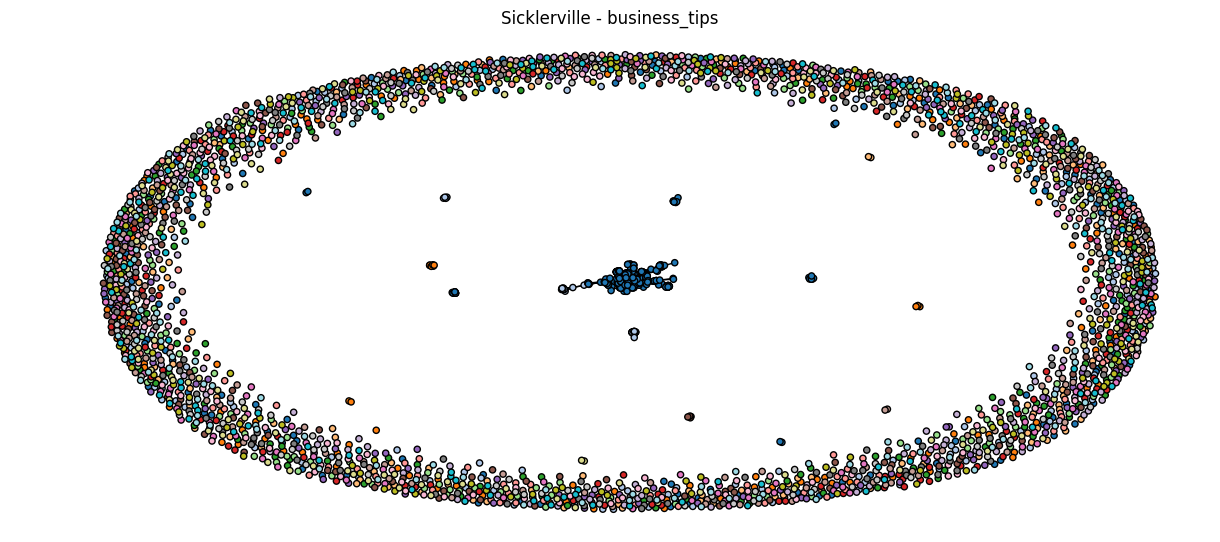

In [17]:
# visualize tip graph

visualize_graph(tip_graph, tip_communities, city, connection)

In [18]:
# load category data

connection = 'categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [19]:
# generate category graph

category_graph = generate_graph(nodes, edges)

In [20]:
# generate category communities

category_communities = generate_communities(category_graph, algorithm='louvain')

print(f"Number of communities: {len(set(category_communities.values()))}")
category_communities

Number of communities: 23


{'RgDVC3ZUBqpEe6Y1kPhIpw': 0,
 'zkamNMEjihh3zN7lC7_WVw': 1,
 'gVFxZMcuG_Tal2_TnpmUPg': 2,
 'g0_x4kVvJAYuk96oCcbOmw': 1,
 '-NbeVN5tnwdyYAvdNkKMjw': 3,
 'cXtE-ZTrNx-hE7usp_f_xg': 4,
 'X6ikCQsAC4QGN-RjmvW2vA': 5,
 'SQ2J0vy4sUIrVfB6_qcbDg': 6,
 'kZnSGYEx0mLVGroGtZiXIA': 4,
 'NEnjlrr2ozU4FMmXup88wA': 7,
 'TVN3qoXU0-sateboutdCZg': 5,
 'cMPJlsuY5IQgJ8N9qICdDw': 6,
 'LI_A-_R6SQotk6fX8C0nPQ': 1,
 'CBk3GqDIhAxm1Sm5uWZynA': 6,
 'vWWvICTldmZgz-JMui2u2w': 5,
 'ApJ9YgYU-AhS4a-F5oTGHw': 1,
 'A_BF2dDDUTKGVXrqxO9mag': 1,
 'B-s-8VUnuBjGTP3d01jsyw': 1,
 'WTNE5YK9RTgP5jzStlbWjQ': 1,
 'wpfvF8ue3yr1m5xD4OrZNw': 1,
 'DsSTEHDUdXQsk7tknLtQSw': 8,
 'bi76Ih6tRv-ghYWFCJ0dag': 1,
 '9C_h-H1Z7Xz7dvbgsBrnSg': 9,
 'ZTvil7E2JbtORKm0bu6MKQ': 1,
 'ie9VaHvAaQgjMJP3Gn-AQQ': 10,
 'zebeVSHqWXuyf5fYATlojA': 4,
 '46Wi08T5D3phf3SMgi7U3w': 6,
 'Vm0fyrUjwMTDgwqV6DhqDw': 1,
 'KwC7I2KR-HlEb3KSH4a0bw': 1,
 'K1atdJqtMk__T3t_aR1sqg': 6,
 't3GdQhAtOP3GYI7JF_49vg': 11,
 '0xEO0EHf9yuNQ0rA59EH1A': 3,
 '8wHKhb9wqIHca43Xr1xJZQ': 3,
 'r3QwSg

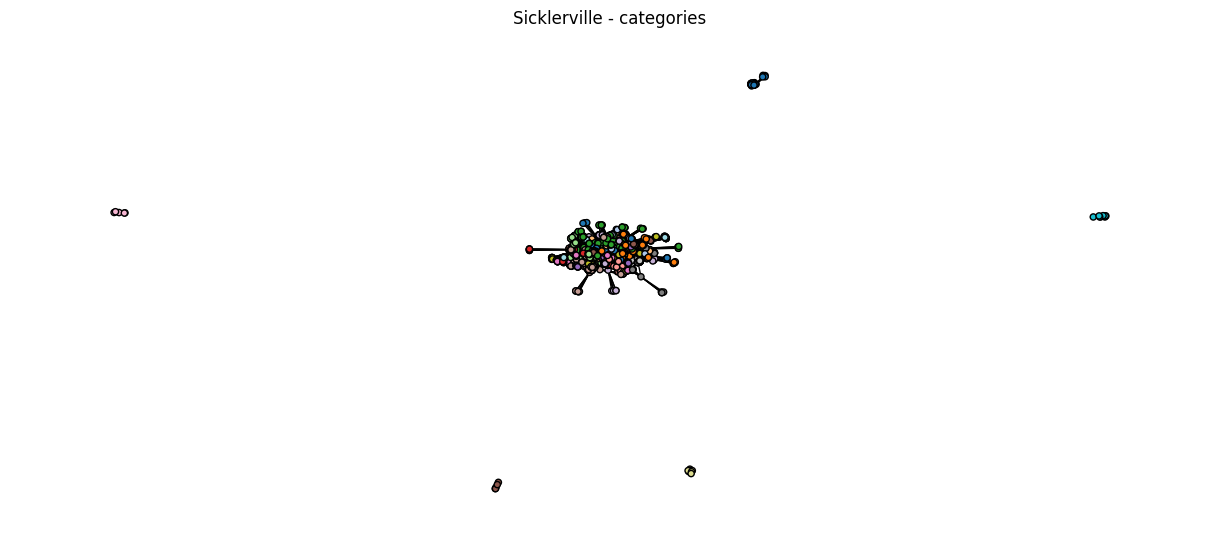

In [21]:
# visualize category graph

visualize_graph(category_graph, category_communities, city, connection)

In [22]:
# load combined data

connection = 'combined'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [23]:
# generate combined graph

combined_graph = generate_graph(nodes, edges)

In [24]:
# generate combined communities

combined_communities = generate_communities(combined_graph, algorithm='louvain')

print(f"Number of communities: {len(set(combined_communities.values()))}")
combined_communities

Number of communities: 21


{'RgDVC3ZUBqpEe6Y1kPhIpw': 8,
 'zkamNMEjihh3zN7lC7_WVw': 1,
 'gVFxZMcuG_Tal2_TnpmUPg': 2,
 'g0_x4kVvJAYuk96oCcbOmw': 3,
 '-NbeVN5tnwdyYAvdNkKMjw': 4,
 'cXtE-ZTrNx-hE7usp_f_xg': 5,
 'X6ikCQsAC4QGN-RjmvW2vA': 6,
 'SQ2J0vy4sUIrVfB6_qcbDg': 6,
 'kZnSGYEx0mLVGroGtZiXIA': 7,
 'NEnjlrr2ozU4FMmXup88wA': 4,
 'TVN3qoXU0-sateboutdCZg': 8,
 'cMPJlsuY5IQgJ8N9qICdDw': 6,
 'LI_A-_R6SQotk6fX8C0nPQ': 1,
 'CBk3GqDIhAxm1Sm5uWZynA': 6,
 'vWWvICTldmZgz-JMui2u2w': 4,
 'ApJ9YgYU-AhS4a-F5oTGHw': 1,
 'A_BF2dDDUTKGVXrqxO9mag': 1,
 'B-s-8VUnuBjGTP3d01jsyw': 1,
 'WTNE5YK9RTgP5jzStlbWjQ': 1,
 'wpfvF8ue3yr1m5xD4OrZNw': 1,
 'DsSTEHDUdXQsk7tknLtQSw': 9,
 'bi76Ih6tRv-ghYWFCJ0dag': 1,
 '9C_h-H1Z7Xz7dvbgsBrnSg': 10,
 'ZTvil7E2JbtORKm0bu6MKQ': 1,
 'ie9VaHvAaQgjMJP3Gn-AQQ': 6,
 'zebeVSHqWXuyf5fYATlojA': 5,
 '46Wi08T5D3phf3SMgi7U3w': 6,
 'Vm0fyrUjwMTDgwqV6DhqDw': 1,
 'KwC7I2KR-HlEb3KSH4a0bw': 1,
 'K1atdJqtMk__T3t_aR1sqg': 6,
 't3GdQhAtOP3GYI7JF_49vg': 10,
 '0xEO0EHf9yuNQ0rA59EH1A': 3,
 '8wHKhb9wqIHca43Xr1xJZQ': 8,
 'r3QwSg

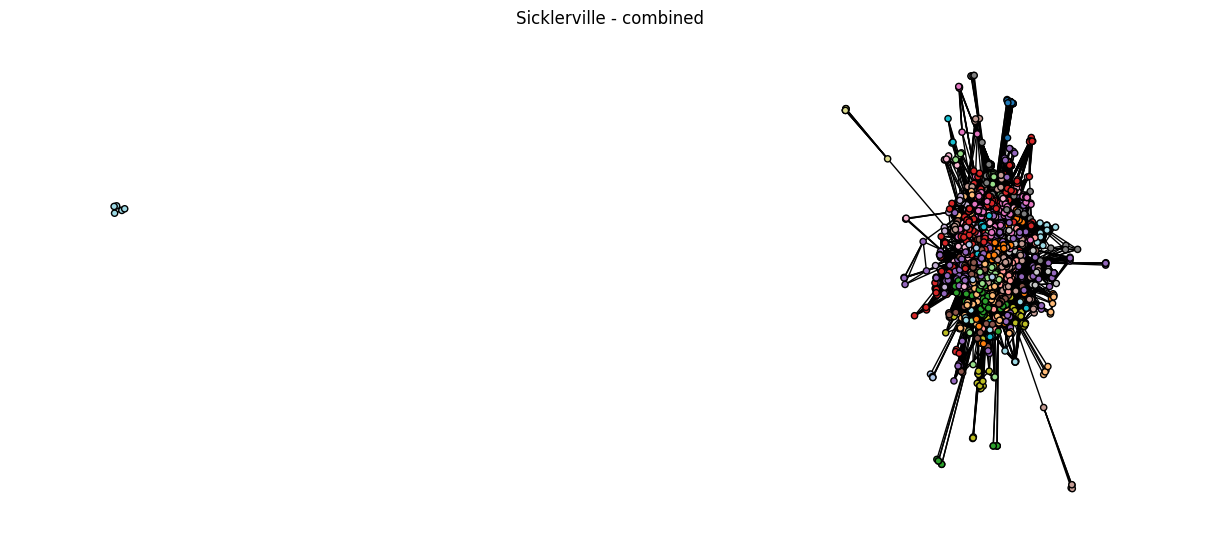

In [25]:
# visualize combined graph

visualize_graph(combined_graph, combined_communities, city, connection)

In [26]:
# graph density

edge_density = nx.density(combined_graph)
print(f"Density: {edge_density:0.4f}")

Density: 0.0371


In [27]:
# graph diameter

is_connected = nx.is_connected(combined_graph)
if is_connected:
    diameter_weighted = nx.diameter(combined_graph, weight='weight')
    print(f"Weighted undirected diameter: {diameter_weighted}")
else:
    print("The graph is not connected.")


The graph is not connected.


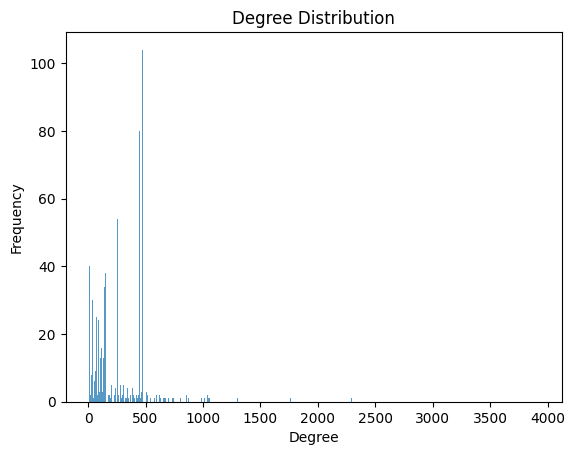

In [28]:
# graph degree distribution

degrees = dict(nx.degree(combined_graph, weight='weight'))

plt.hist(degrees.values(), bins=range(1, max(degrees.values()) + 2), alpha=0.75)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

In [ ]:
# closeness centrality

closeness = nx.closeness_centrality(combined_graph, distance='weight')

closeness_df = pd.DataFrame({'name': list(closeness.keys()), 'closeness': list(closeness.values())})
closeness_df = closeness_df.sort_values(by='closeness', ascending=False)

closeness_df

# taking too long to compute (when considering weights)

In [30]:
# betweenness centrality

betweenness = nx.betweenness_centrality(combined_graph, k=500, weight='weight')

betweenness_df = pd.DataFrame({'name': list(betweenness.keys()), 'betweenness': list(betweenness.values())})
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)

betweenness_df

# running with a representative sample so it doesn't take forever

,name,betweenness
367,ePxjx8tee06mn5h87X-Sxg,0.046682
84,178lUNiULUgxi8fdm1zXmA,0.042248
1141,NRn5ddCUt1QgnPnRnTgK2Q,0.039958
2988,eou_N8D5TBvS3d9-tgNf2g,0.033686
337,6Q8dQGr_DBKcmQ1aXVWvTQ,0.033542
...,...,...
2219,33kT5T_g9Gpuxrn7xhvxWA,0.000000
2221,Don38MeRTHtj8XJLMeYnvQ,0.000000
2222,p9gpDqODX6u0CoBGmtAlow,0.000000
831,G_a9M9WnQWrvYST6zX9RlQ,0.000000


In [31]:
# edge betweenness centrality

edge_betweenness = nx.edge_betweenness_centrality(combined_graph, k=500, weight='weight')

edge_betweenness

# running with a representative sample so it doesn't take forever

{('RgDVC3ZUBqpEe6Y1kPhIpw', '-XZOz3ViFET3IZFRGFoOpQ'): 8.128065182386265e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', '1C5kFjSPdf9P74IhPy6e-w'): 3.9686674901459114e-07,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', '1n3IENFR9dpPztzTh0A6dA'): 3.5953692610253577e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', '3Qqi2SFrqZDmzb_txv3yaQ'): 2.4070395985937266e-05,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', '4TE2IPdI9_4dYAalTGImUg'): 3.5953692610253577e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', '8DGc1UEegk6SBGV39OJtQA'): 3.5953692610253577e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', '9C_h-H1Z7Xz7dvbgsBrnSg'): 3.992792133884211e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', 'A_BF2dDDUTKGVXrqxO9mag'): 2.0983427879678967e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', 'ApJ9YgYU-AhS4a-F5oTGHw'): 7.1149298771161326e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', 'B-s-8VUnuBjGTP3d01jsyw'): 2.6729615287643e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', 'ET8n-r7glWYqZhuR6GcdNw'): 7.730866416432555e-07,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', 'FV6QtuA5P52Cm5q7SOeMLQ'): 3.5953692610253577e-06,
 ('RgDVC3ZUBqpEe6Y1kPhIpw', 'JSpwp4pAp_Hu4xmPuNitBA'): 2.4

In [ ]:
# average shortest path length

if nx.is_connected(combined_graph):
    mean_dist = nx.average_shortest_path_length(combined_graph, weight='weight')
    print(f"Average path length: {mean_dist:.3f}")
else:
    connected_components = nx.connected_components(combined_graph)
    for component in connected_components:
        component_graph = combined_graph.subgraph(component)
        avg_path_length = nx.average_shortest_path_length(component_graph, weight='weight')
        print(f"Component: {component}, Average shortest path length: {avg_path_length:.3f}")

# taking too long to compute

In [32]:
# graph homophily

homophily = nx.degree_assortativity_coefficient(combined_graph, weight='weight')

print(f"All network = {homophily:.3f}")

All network = -0.008
